In [20]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [21]:
result_dir='problem_baseline_results_generalization_new'
seeds=[2,150,500,750,1000, '2-150-500-750-1000']
seeds=[2,150,500,750,1000]
visualizations_dir='problem_baseline_visualizations_generalization'
algorithms='ES'
iteration_start,iteration_end=0,29
train_on_seed=False
difference=False

seed_mapping={2:'0',150:'1',500:'2',750:'3',1000:'4', '2-150-500-750-1000':'all'}

In [22]:
def get_global_file_name(algorithms, iteration_start,iteration_end, train_on_seed,seed, difference):
    return os.path.join(result_dir,f'{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed_{seed}{"_differenced" if difference else ""}')



def get_visualization_output_name_without_seed(algorithms, iteration_start,iteration_end, train_on_seed, difference):
    return os.path.join(visualizations_dir,f'{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}')

In [5]:
all_accuracies_df=pd.DataFrame()
for seed in seeds:
    seed_accuracies=[]
    for fold in range(0,10):
        file_location=get_global_file_name(algorithms, iteration_start,iteration_end, train_on_seed,seed, difference) +f'_fold_{fold}_report.csv'
        if not os.path.isfile(file_location):
            print('Not found', file_location)
            continue
        fold_report_df=pd.read_csv(file_location, index_col=[0])
        seed_accuracies+=[fold_report_df.loc['support','accuracy']]
    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy']
        seed_accuracy_df['seed']=seed
        all_accuracies_df=pd.concat([all_accuracies_df,seed_accuracy_df]) 

In [8]:
def get_seed_accuracies_df(algorithms, iteration_start, iteration_end, train_on_seed, difference, seeds):
    seed_accuracies=[]
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(algorithms, iteration_start,iteration_end, train_on_seed,train_seed, difference)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip')
            
            test_df_fold['fold']=fold
            test_df_fold['train_seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])



        for test_seed in seeds:
            for fold in range(0,10):
                seed_preds_df=test_df.query('seed==@test_seed and fold==@fold')
                seed_accuracies+=[(accuracy_score(seed_preds_df['y'], seed_preds_df['preds']), train_seed, test_seed)]


    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy','train_seed','test_seed']
        return seed_accuracy_df, test_df_all
    return None

In [17]:
results=[]
for algorithms_1 in ['DE','GA','CMAES','ES']:
    for train_on_seed_1 in [True, False]:
        for difference_1 in [False]:
            seed_accuracy_df,_ = get_seed_accuracies_df(algorithms_1, iteration_start, iteration_end, train_on_seed_1, difference_1, seeds)

            median_accuracy = seed_accuracy_df.query("train_seed!=test_seed").median()['accuracy']
            mean_accuracy = seed_accuracy_df.query("train_seed!=test_seed").mean()['accuracy']
            std_accuracy = seed_accuracy_df.query("train_seed!=test_seed").std()['accuracy']
            results += [(algorithms_1, 1 if train_on_seed_1 else 4, 4 if train_on_seed_1 else 1,  median_accuracy, mean_accuracy, std_accuracy)]
results_summary_df=pd.DataFrame(results, columns=['Algorithm','Training runs','Testing runs','Median accuracy','Mean accuracy', 'Standard deviation of accuracy'] )


In [18]:
results_summary_df.to_latex(f'{visualizations_dir}/median_accuracy_summary.tex', index=False)

/tmp/ipykernel_114/84892811.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results_summary_df.to_latex(f'{visualizations_dir}/median_accuracy_summary.tex', index=False)


/tmp/ipykernel_3145/791025292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['test_seed']=df_to_plot['test_seed'].apply(lambda s: seed_mapping[s])
/tmp/ipykernel_3145/791025292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['test_seed']=df_to_plot['test_seed'].apply(lambda s: seed_mapping[s])
/tmp/ipykernel_3145/791025292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

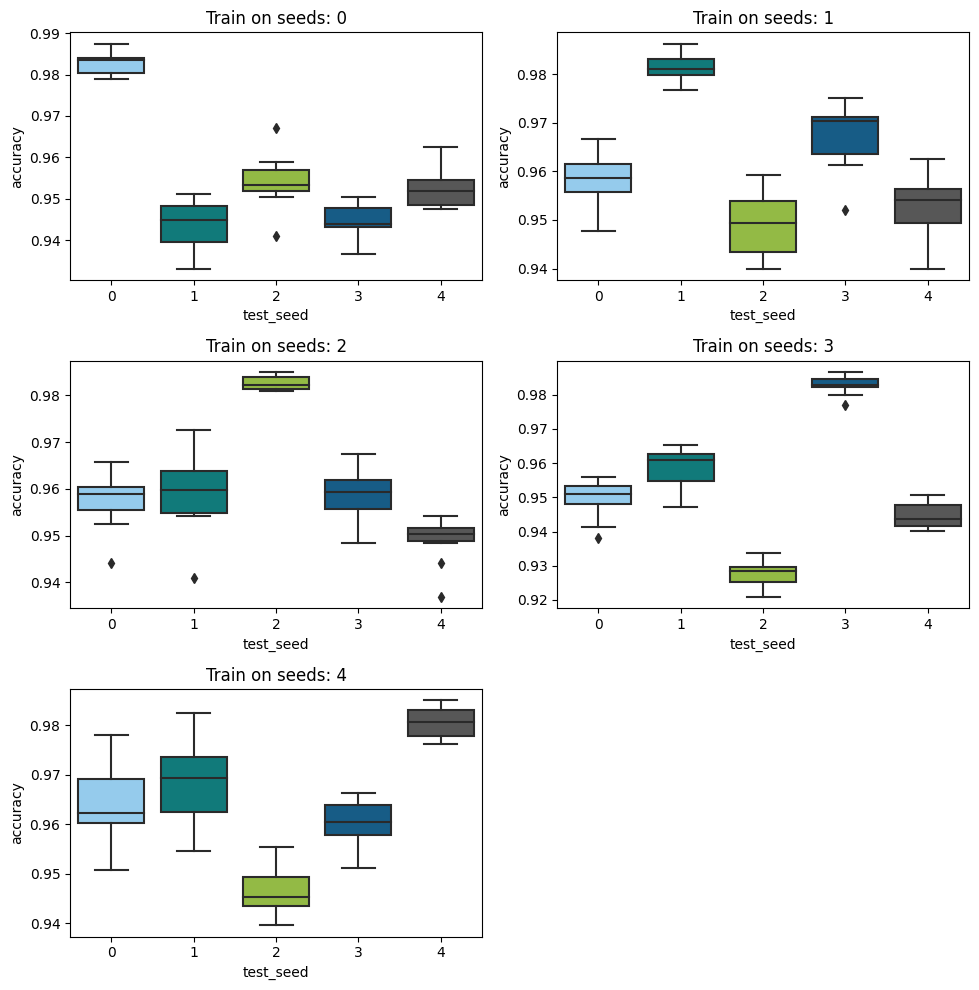

In [10]:
fig, axes = plt.subplots(3,2, figsize=(10,10))
for seed_index, seed in enumerate(seeds):
    df_to_plot=seed_accuracy_df.query('train_seed==@seed')
    df_to_plot['test_seed']=df_to_plot['test_seed'].apply(lambda s: seed_mapping[s])
    ax=axes[int(seed_index/2)][seed_index%2]
    sns.boxplot(df_to_plot,y='accuracy', x='test_seed', palette=color_palette, ax= ax)
    training_seeds = str(seed_mapping[seed]) if train_on_seed else ','.join([seed_mapping[ss] for ss in list(filter(lambda s:s!=seed, seeds))])
    test_seeds = str(seed_mapping[seed]) if not train_on_seed else ','.join([seed_mapping[ss] for ss in list(filter(lambda s:s!=seed, seeds))])

    
    ax.set_title(f'Train on seeds: {training_seeds}')

plt.tight_layout()
fig.delaxes(axes[2][1])
file_name=get_visualization_output_name_without_seed(algorithms, iteration_start,iteration_end, train_on_seed, difference) + '_generalization_accuracy_boxplots.pdf'
plt.savefig(file_name)

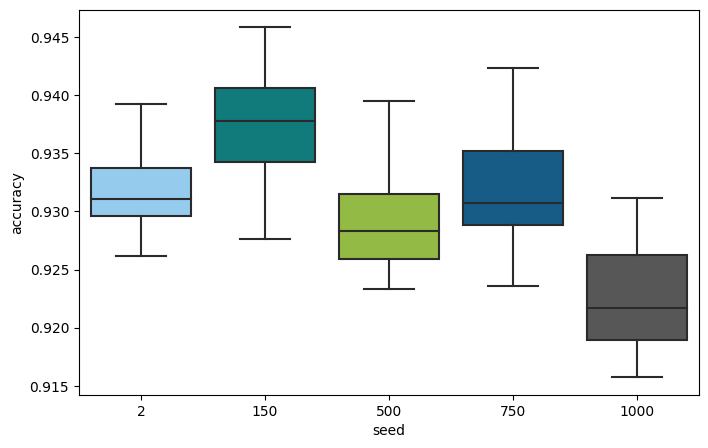

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(all_accuracies_df,y='accuracy', x='seed', palette=color_palette)
plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_accuracy_boxplots.pdf'))

In [ ]:
for algorithm_name_1 in ['DE','GA','ES','CMAES']:
    for train_on_seed_1 in [False,True]:
        seed_accuracy_df,test_df_all = get_seed_accuracies_df(algorithm_name_1, iteration_start=0, iteration_end=29, train_on_seed=train_on_seed_1, difference=False, seeds=seeds)
        #test_df_all=test_df_all.query('train_seed==seed')
        fig, ax= plt.subplots(1,1,figsize=(15,13), sharey=True,squeeze=True)
        d=ConfusionMatrixDisplay.from_predictions(test_df_all['y'], test_df_all['preds'],cmap=my_cmap, colorbar=True, ax=ax)

        plt.xticks(rotation=90)

        #ax.set_xticklabels(ax.get_xticks(), rotation = 90)
        plt.tight_layout()
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(16)
        file_name=f'{algorithm_name_1}_{iteration_start}-{iteration_end}_train_on_seed_{train_on_seed_1}_final_confusion_matrices_all_seeds.pdf'
        print(file_name)
        plt.savefig(os.path.join(visualizations_dir,file_name))

In [ ]:
row_count=5
col_count=1
#fig, axes= plt.subplots(row_count,col_count,figsize=(row_count*5+2, col_count*5-2), sharey=True,squeeze=False)


fig, axes= plt.subplots(row_count,col_count,figsize=(9,30), sharey=True,squeeze=False)
print(row_count,col_count)
for seed_idx,seed in enumerate(seeds):
    seed_predictions_df=test_df_all.query('train_seed==@seed')

    ax=axes[int(seed_idx/col_count)][int(seed_idx)%col_count]
    d=ConfusionMatrixDisplay.from_predictions(seed_predictions_df['y'], seed_predictions_df['preds'],cmap=my_cmap, ax=ax, colorbar=False)
    
    ax.set_title(f'Seed: {str(seed)}')
    #d.figure_.savefig(f'algorithm_baseline_results/{run_name}_confusion.pdf')
    plt.xticks(rotation=90)
    
    ax.tick_params(axis='x', labelrotation=90)
    #ax.set_xticklabels(ax.get_xticks(), rotation = 90)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_confusion_matrices_individual_seeds.pdf'))

In [48]:
all_feature_importances_df

,mean it_0 x_0,mean it_0 x_1,mean it_0 x_2,mean it_0 y,min it_0 x_0,min it_0 x_1,min it_0 x_2,min it_0 y,max it_0 x_0,max it_0 x_1,...,min it_29 y,max it_29 x_0,max it_29 x_1,max it_29 x_2,max it_29 y,std it_29 x_0,std it_29 x_1,std it_29 x_2,std it_29 y,algorithm
0,0.000011,0.000009,0.000008,0.010688,0.000009,0.000010,0.000011,0.000436,0.000009,0.000011,...,0.000253,0.000517,0.000104,0.000547,0.000065,0.004667,0.009881,0.011023,0.010910,DE
0,0.000012,0.000012,0.000012,0.015877,0.000011,0.000014,0.000011,0.000231,0.000009,0.000015,...,0.000286,0.000516,0.000149,0.000261,0.000069,0.005005,0.008763,0.008938,0.012796,DE
0,0.000012,0.000013,0.000012,0.016419,0.000009,0.000010,0.000009,0.000208,0.000009,0.000008,...,0.000157,0.000189,0.000106,0.000386,0.000084,0.005661,0.007111,0.010705,0.014504,DE
0,0.000010,0.000012,0.000011,0.012329,0.000009,0.000009,0.000009,0.000131,0.000012,0.000011,...,0.000225,0.000267,0.000142,0.000237,0.000069,0.006886,0.009434,0.011144,0.010396,DE
0,0.000012,0.000010,0.000013,0.014976,0.000012,0.000011,0.000011,0.000174,0.000011,0.000011,...,0.000174,0.000283,0.000147,0.000218,0.000067,0.005889,0.008174,0.006533,0.017420,DE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000009,0.000007,0.000010,0.012520,0.000011,0.000011,0.000009,0.000489,0.000012,0.000016,...,0.000232,0.000350,0.000153,0.000613,0.000087,0.007132,0.008529,0.014872,0.009493,CMAES
0,0.000011,0.000012,0.000013,0.014546,0.000010,0.000007,0.000009,0.000154,0.000016,0.000011,...,0.000265,0.000114,0.000247,0.000190,0.000071,0.005878,0.008111,0.009680,0.011502,CMAES
0,0.000012,0.000012,0.000014,0.013597,0.000010,0.000008,0.000013,0.000185,0.000009,0.000014,...,0.000186,0.000360,0.000151,0.000319,0.000068,0.005443,0.007333,0.009593,0.013282,CMAES
0,0.000011,0.000012,0.000015,0.012013,0.000012,0.000013,0.000014,0.000914,0.000014,0.000010,...,0.000216,0.000346,0.000157,0.000417,0.000072,0.005430,0.009164,0.012734,0.016485,CMAES


In [51]:
all_feature_importances_df=pd.DataFrame()
for seed in seeds:
    for algorithm in ['DE','GA','ES','CMAES']:
         for fold in range(0,10):

            global_file_name=get_global_file_name(algorithms, iteration_start,iteration_end, train_on_seed,seed, difference)
            file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            fold_importance_df=pd.read_csv(file_location, index_col=[0], compression='zip')
            fold_importance_df['seed']=seed
            fold_importance_df['fold']=fold
            fold_importance_df['algorithm']=algorithm
            all_feature_importances_df=pd.concat([all_feature_importances_df, fold_importance_df])


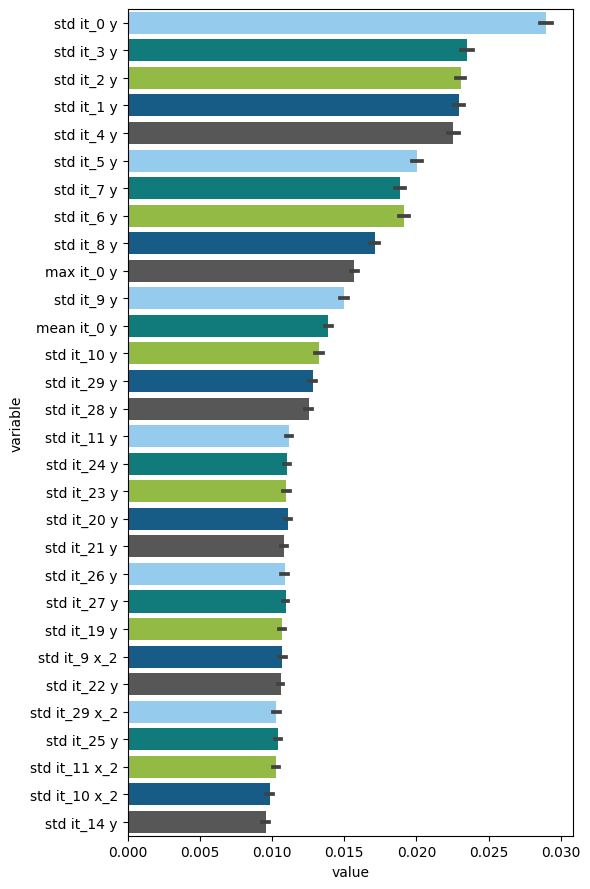

In [61]:
id_vars=['algorithm','seed','fold']
top_30_features=list(all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(30).index)


all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_30_features+id_vars], id_vars=id_vars, value_vars=top_30_features)
plt.figure(figsize=(6,9))

sns.barplot(all_feature_importances_df_melted, y='variable',x='value',palette=color_palette)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,'top_30_feature_importance.pdf'))

In [49]:
if iteration_end<10:
    all_feature_importances_df_melt=pd.melt(all_feature_importances_df, id_vars=['seed','fold'],value_vars=list(set(all_feature_importances_df.columns).difference({'seed','fold'})), value_name='Importance', var_name='Feature')

    all_feature_importances_df_melt['Feature type']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0])
    all_feature_importances_df_melt['Iteration']=all_feature_importances_df_melt['Feature'].apply(lambda x: int(x.split(' ')[1].split('_')[1]))
    all_feature_importances_df_melt['Feature aggregated across dimensions']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1].split('_')[1])

    all_feature_importances_df_melt=all_feature_importances_df_melt.sort_values(['Iteration','Feature type'])

    #plt.figure(figsize=(40,10))
    fig, axes= plt.subplots(1,1,figsize=(10,3), sharey=True)
    sns.boxplot(all_feature_importances_df_melt.query('Iteration<10'),y='Importance', x='Feature aggregated across dimensions',  palette=color_palette_4, ax=axes)
    axes.tick_params(axis='x', labelrotation=90)

    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_feature_importance_across_iterations.pdf'))

In [50]:
all_feature_importances_df.drop(columns=['seed','fold']).mean().sort_values()

KeyError: "['seed', 'fold'] not found in axis"

In [57]:
all_feature_importances_df

,mean it_0 x_0,mean it_0 x_1,mean it_0 x_2,mean it_0 y,min it_0 x_0,min it_0 x_1,min it_0 x_2,min it_0 y,max it_0 x_0,max it_0 x_1,...,max it_29 x_1,max it_29 x_2,max it_29 y,std it_29 x_0,std it_29 x_1,std it_29 x_2,std it_29 y,seed,fold,algorithm
0,0.000011,0.000009,0.000008,0.010688,0.000009,0.000010,0.000011,0.000436,0.000009,0.000011,...,0.000104,0.000547,0.000065,0.004667,0.009881,0.011023,0.010910,2,0,DE
0,0.000012,0.000012,0.000012,0.015877,0.000011,0.000014,0.000011,0.000231,0.000009,0.000015,...,0.000149,0.000261,0.000069,0.005005,0.008763,0.008938,0.012796,2,1,DE
0,0.000012,0.000013,0.000012,0.016419,0.000009,0.000010,0.000009,0.000208,0.000009,0.000008,...,0.000106,0.000386,0.000084,0.005661,0.007111,0.010705,0.014504,2,2,DE
0,0.000010,0.000012,0.000011,0.012329,0.000009,0.000009,0.000009,0.000131,0.000012,0.000011,...,0.000142,0.000237,0.000069,0.006886,0.009434,0.011144,0.010396,2,3,DE
0,0.000012,0.000010,0.000013,0.014976,0.000012,0.000011,0.000011,0.000174,0.000011,0.000011,...,0.000147,0.000218,0.000067,0.005889,0.008174,0.006533,0.017420,2,4,DE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000009,0.000007,0.000010,0.012520,0.000011,0.000011,0.000009,0.000489,0.000012,0.000016,...,0.000153,0.000613,0.000087,0.007132,0.008529,0.014872,0.009493,1000,5,CMAES
0,0.000011,0.000012,0.000013,0.014546,0.000010,0.000007,0.000009,0.000154,0.000016,0.000011,...,0.000247,0.000190,0.000071,0.005878,0.008111,0.009680,0.011502,1000,6,CMAES
0,0.000012,0.000012,0.000014,0.013597,0.000010,0.000008,0.000013,0.000185,0.000009,0.000014,...,0.000151,0.000319,0.000068,0.005443,0.007333,0.009593,0.013282,1000,7,CMAES
0,0.000011,0.000012,0.000015,0.012013,0.000012,0.000013,0.000014,0.000914,0.000014,0.000010,...,0.000157,0.000417,0.000072,0.005430,0.009164,0.012734,0.016485,1000,8,CMAES


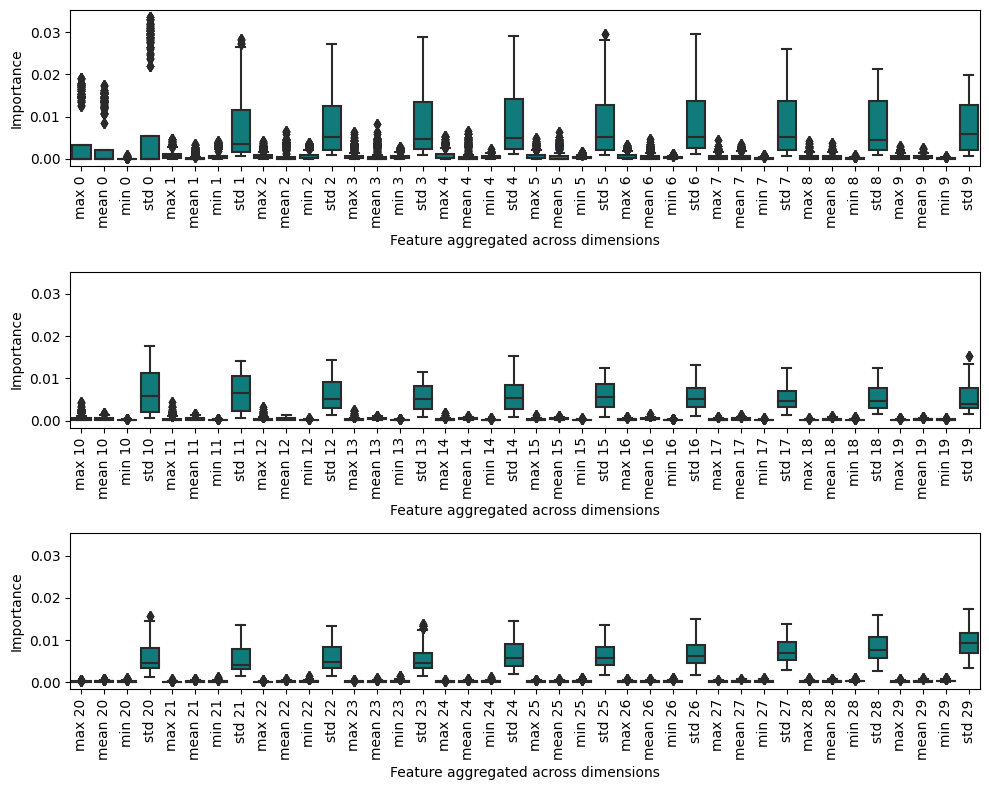

In [74]:
if iteration_end>20:
    all_feature_importances_df_melt=pd.melt(all_feature_importances_df, id_vars=id_vars,value_vars=list(set(all_feature_importances_df.columns).difference(set(id_vars))), value_name='Importance', var_name='Feature')

    all_feature_importances_df_melt['Feature type']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0])
    all_feature_importances_df_melt['Iteration']=all_feature_importances_df_melt['Feature'].apply(lambda x: int(x.split(' ')[1].split('_')[1]))
    all_feature_importances_df_melt['Feature aggregated across dimensions']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1].split('_')[1])

    all_feature_importances_df_melt=all_feature_importances_df_melt.sort_values(['Iteration','Feature type'])

    #plt.figure(figsize=(40,10))
    fig, axes= plt.subplots(3,1,figsize=(10,8), sharey=True)
    sns.boxplot(all_feature_importances_df_melt.query('Iteration<10'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[0])
    sns.boxplot(all_feature_importances_df_melt.query('Iteration>=10 and Iteration <20'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[1])

    sns.boxplot(all_feature_importances_df_melt.query('Iteration>=20'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[2])
    axes[0].tick_params(axis='x', labelrotation=90)
    axes[1].tick_params(axis='x', labelrotation=90)
    axes[2].tick_params(axis='x', labelrotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'all_algs_{iteration_start}-{iteration_end}_feature_importance_across_iterations.pdf'))

In [25]:
top_feature_importances=[]
feature_importance_scores=pd.DataFrame()
for seed in seeds:
    seed_feature_importances_df=all_feature_importances_df.query('seed==@seed')
    sorted_feature_importance=seed_feature_importances_df.drop(columns=['seed']).median().sort_values(ascending=False).to_frame()
    top_features = list(sorted_feature_importance.index)[:20]+['seed']
    
    sorted_feature_importance['rank']=list(range(0,sorted_feature_importance.shape[0]))
    
    sorted_feature_importance['seed']=seed
    feature_importance_scores=pd.concat([feature_importance_scores,sorted_feature_importance.reset_index()])
    top_feature_importances+=top_features
    all_feature_importances=[]
    for index, row in seed_feature_importance_df[top_features ].iterrows():
        for index2 in row.keys():
            if index2!='seed':
                all_feature_importances+=[(index,index2,row[index2],row['seed'])]
    feature_importance_df=pd.DataFrame(all_feature_importances, columns=['fold','feature_name','importance','seed'])
    plt.figure()
    sns.boxplot(feature_importance_df,y='importance', x='feature_name',  palette=color_palette)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_top_20_features_boxplots_seeds_{seed}.pdf'))
print(pd.DataFrame(top_feature_importances).value_counts())
print(feature_importance_scores)
    

/tmp/ipykernel_114/1876796556.py:5: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_feature_importance=seed_feature_importances_df.drop(columns=['seed']).median().sort_values(ascending=False).to_frame()


NameError: name 'seed_feature_importance_df' is not defined